In [87]:
from ml_battery import *
import ml_battery.nhts_data as nhts_data
import sklearn.pipeline
import pickle
import pandas as pd
import numpy as np
import sklearn.ensemble
import sklearn.svm
import sklearn.linear_model
import sklearn.cross_validation
import matplotlib.pyplot as plt

In [88]:
USE_PRETRAINED=True

In [89]:
df_trip = nhts_data.load_nhts.trip()

In [90]:
df_trip["real_strttime"] = (df_trip["STRTTIME"].floordiv(100))*60 + df_trip["STRTTIME"].mod(100)

In [91]:
df_from_work_trips = df_trip[df_trip["WHYFROM"] == 3].drop("WHYFROM", axis=1)
df_to_work_trips = df_trip[df_trip["WHYTO"] == 3].drop("WHYTO", axis=1)

In [92]:
df_workin_all_day = df_from_work_trips.merge(df_to_work_trips, on=["HOUSEID", "PERSONID", "TDAYDATE"], suffixes=("_fromwork",""))

In [93]:
df_unique_workin_all_day = df_workin_all_day.drop_duplicates(subset=["HOUSEID","PERSONID","TDAYDATE"], keep=False)

In [94]:
dups = duplicate_columns(df_unique_workin_all_day)
df_unique_workin_all_day_deduped = df_unique_workin_all_day.drop(dups, axis=1)

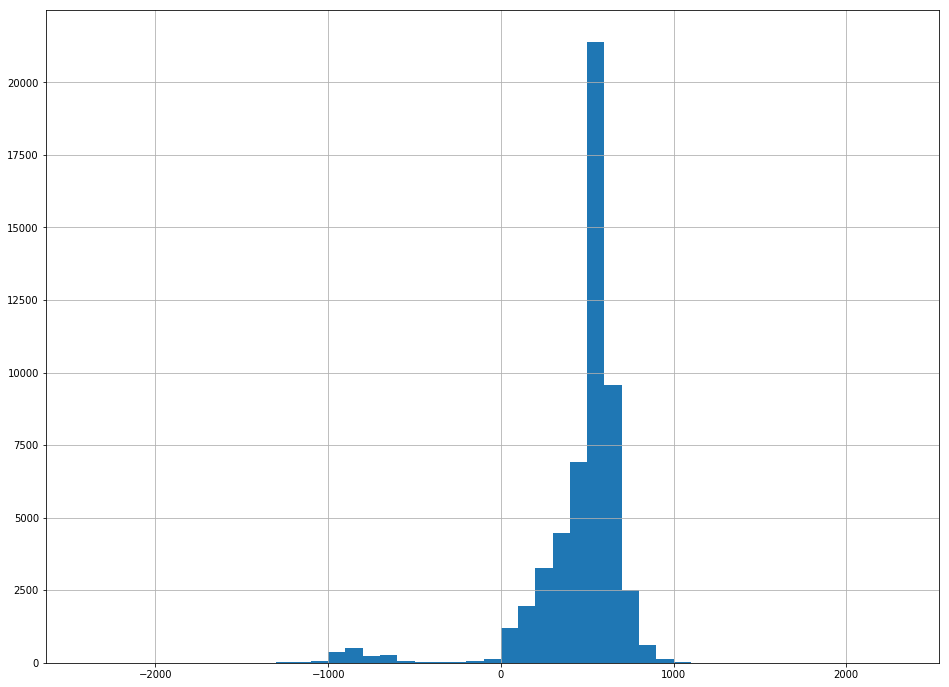

In [95]:
f = plt.figure(figsize=(16,12))
hist = (df_unique_workin_all_day_deduped["real_strttime_fromwork"] - df_unique_workin_all_day_deduped["real_strttime"]).hist(bins=list(range(-2400,2400,100)))
plt.show()

In [96]:
df_unique_workin_all_day_deduped["work_strttime_endtime_discretized"] = df_unique_workin_all_day_deduped["real_strttime"].floordiv(60).astype(str) + "_" + df_unique_workin_all_day_deduped["real_strttime_fromwork"].floordiv(60).astype(str)

In [97]:
df_hh = nhts_data.load_nhts.household()
df_per = nhts_data.load_nhts.person()

In [98]:
df = df_unique_workin_all_day_deduped.merge(df_hh).merge(df_per)

In [99]:
df.shape

(53937, 258)

In [100]:
dups = duplicate_columns(df)
df.drop(dups, inplace=True, axis=1)

In [101]:
X_columns = set(df.columns.values.tolist()) - set(["STRTTIME", "STRTIME_fromwork", "real_strttime", "real_strttime_fromwork", "work_strttime_endtime_discretized", "WTTRDFIN", "WTHHFIN", "WTPERFIN"])
X_columns = sorted(X_columns)

y_columns = ["work_strttime_endtime_discretized"]

weight_column = "WTTRDFIN"

In [102]:
np.unique(df[y_columns[0]]).shape

(419,)

In [103]:
threshold = 10 # Anything that occurs less than this will be removed.
value_counts = df[y_columns[0]].value_counts()
to_remove = value_counts[value_counts <= threshold].index
df[y_columns[0]] = df[y_columns[0]].replace(to_remove, np.nan)

In [104]:
df = df.dropna()

In [109]:
np.unique(df[y_columns[0]]).shape

(222,)

In [105]:
data_train, data_test = sklearn.cross_validation.train_test_split(df, test_size=0.2, random_state=0, stratify=df[y_columns])

In [106]:
X_train, y_train, weights_train = data_train[X_columns], data_train[y_columns], data_train[weight_column]
X_test, y_test, weights_test = data_test[X_columns], data_test[y_columns], data_test[weight_column]

In [107]:
X_train.shape

(42600, 249)

In [108]:
np.unique(y_train).shape

(222,)

In [21]:
np.unique(df[y_columns]).shape

(222,)

In [22]:
codebooks = nhts_data.load_nhts.codebook(sheet_name=None)

In [23]:
codebook = codebooks["CODEBOOK_HH"].merge(codebooks["CODEBOOK_PER"], how="outer").merge(codebooks["CODEBOOK_TRIP"], how="outer")

In [24]:
codebook = codebook[['Name','Label','Type']]
codebook_fromwork = codebook.copy()
codebook_fromwork["Name"] += "_fromwork"
codebook = pd.concat((codebook, codebook_fromwork), ignore_index=True)
codebook = codebook.dropna().drop_duplicates().set_index('Name')
print(codebook.loc["BIKE"]["Label"], codebook.loc["BIKE"]["Type"])

Frequency of Bicycle Use for Travel C


In [25]:
clf = sklearn.pipeline.Pipeline([
    ('data_transformation', CodebookTransformer(codebook, X_possible_values = df)),
    ('feature_selection', SelectFromModelPandas(sklearn.ensemble.RandomForestClassifier(n_jobs=-1))),
    ('classification', StackedEstimator(
        MultiEstimator([
            ("random forest", HyperparameterOptimizedEstimator(sklearn.ensemble.RandomForestClassifier(n_jobs=-1), max_depth=(2,10))),
            ("logistic regression", sklearn.linear_model.LogisticRegression(C=100000)),
            ("one-hidden mlp, 1000 epochs, optimized hidden", HyperparameterOptimizedEstimator(OneLayerNNClassifier(n_epochs=1000, regularization=0.01, dropout=1), n_hidden=(1,100))),
            #("linear SVC", sklearn.svm.LinearSVC(C=100000)),
            #("rbf SVC", sklearn.svm.SVC(kernel="rbf")),
            #("linear regression (rounded to nearest int)", IntegerRegressor(sklearn.linear_model.LinearRegression())),
            ("naive bayes", MixedNB()),
            #("one-hidden MLP, 1000 epochs, 20 hidden", OneLayerNNClassifier(20, 1000, batch_size=300, learning_rate=0.001)),
            #("one-hidden MLP, 1000 epochs, 1 hidden", OneLayerNNClassifier(1,1000)),
            #("one-hidden MLP, 10000 epochs, 1 hidden", OneLayerNNClassifier(1,10000)),
            ("stratified dummy", PatchedDummy()),
            #("ordered probit", OrdinalRegression("probit")),
            #("nested ordinal logit", NestedClassifier(sklearn.linear_model.LogisticRegression(C=1000), [0,[1,[2,[3,[4,[5,[6,[7,[8,[9,[10,[11,12]]]]]]]]]]]])),
        ], parallel=True),
        sklearn.linear_model.LogisticRegression(C=100000)
    ))
])

In [26]:
if USE_PRETRAINED:
    with open("../models/NHTS_worktime_pipeline.p","rb") as f:
        toy_pipeline = pickle.load(f)
    clf=toy_pipeline
else:
    print("fitting!")
    clf.fit(X_train, y_train, classification__sample_weight=weights_train)
    with open("../models/NHTS_worktime_pipeline.p","wb") as f:
        pickle.dump(clf,f)

In [76]:
def blah(*args, **kwargs):
    return None, np.zeros((7405, 7405))
permutation_importance.get_score_importances = blah

In [77]:
(stacked_scores, stacked_cm, stacked_fi), (multi_scores, multi_cm, multi_fi) = clf.score(X_test, y_test, sample_weight=weights_test)

/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [78]:
stacked_scores

accuracy                                          0.592561
weighted f1                                       0.576876
weighted precision                                0.586613
weighted recall                                   0.592561
macro f1                                          0.293642
macro precision                                   0.338962
macro recall                                      0.292311
log loss                                         12.839344
macro mean absolute market share error          154.544665
weighted mean absolute market share error         0.248538
training time                                194215.423166
dtype: float64

In [79]:
multi_scores

,random forest,logistic regression,"one-hidden mlp, 1000 epochs, optimized hidden",naive bayes,stratified dummy
accuracy,0.211776,0.572185,0.626112,0.259720,0.031537
weighted f1,0.148739,0.560219,0.598995,0.299503,0.029844
weighted precision,0.214188,0.571479,0.584566,0.438184,0.028878
weighted recall,0.211776,0.572185,0.626112,0.259720,0.031537
macro f1,0.024357,0.290472,0.251577,0.115194,0.003862
macro precision,0.064150,0.333691,0.241867,0.178846,0.003768
macro recall,0.024504,0.291570,0.286306,0.142027,0.004106
log loss,3.656228,3.942233,1.967947,20.362821,33.416672
macro mean absolute market share error,211.668822,152.783599,279.702112,1116.606793,250.511011
weighted mean absolute market share error,1.146497,0.235237,0.348431,0.885585,0.303680


In [80]:
clf

Pipeline(memory=None,
     steps=[('data_transformation', <ml_battery.ml_helpers.CodebookTransformer object at 0x7feb484d96a0>), ('feature_selection', SelectFromModelPandas(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None..., PatchedDummy(constant=None, random_state=None, strategy='stratified'))],
        parallel=True)))])

In [81]:
multi_scores["stacked model"] = stacked_scores

In [82]:
multi_scores

,random forest,logistic regression,"one-hidden mlp, 1000 epochs, optimized hidden",naive bayes,stratified dummy,stacked model
accuracy,0.211776,0.572185,0.626112,0.259720,0.031537,0.592561
weighted f1,0.148739,0.560219,0.598995,0.299503,0.029844,0.576876
weighted precision,0.214188,0.571479,0.584566,0.438184,0.028878,0.586613
weighted recall,0.211776,0.572185,0.626112,0.259720,0.031537,0.592561
macro f1,0.024357,0.290472,0.251577,0.115194,0.003862,0.293642
macro precision,0.064150,0.333691,0.241867,0.178846,0.003768,0.338962
macro recall,0.024504,0.291570,0.286306,0.142027,0.004106,0.292311
log loss,3.656228,3.942233,1.967947,20.362821,33.416672,12.839344
macro mean absolute market share error,211.668822,152.783599,279.702112,1116.606793,250.511011,154.544665
weighted mean absolute market share error,1.146497,0.235237,0.348431,0.885585,0.303680,0.248538


In [83]:
clf.steps[-1][1].multiestimator.estimators[0][1]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
print(multi_scores.round(3).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  random forest &  logistic regression &  one-hidden mlp, 1000 epochs, optimized hidden &  naive bayes &  stratified dummy &  stacked model \\
\midrule
accuracy                                  &          0.212 &                0.572 &                                          0.626 &        0.260 &             0.032 &          0.593 \\
weighted f1                               &          0.149 &                0.560 &                                          0.599 &        0.300 &             0.030 &          0.577 \\
weighted precision                        &          0.214 &                0.571 &                                          0.585 &        0.438 &             0.029 &          0.587 \\
weighted recall                           &          0.212 &                0.572 &                                          0.626 &        0.260 &             0.032 &          0.593 \\
macro f1                                  &          0.024 &      

# Training data scores

In [35]:
(stacked_scores, stacked_cm, stacked_fi), (multi_scores, multi_cm, multi_fi) = clf.score(X_train, y_train, sample_weight=weights_train)

/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
multi_scores["stacked model"] = stacked_scores
multi_scores

,random forest,logistic regression,"one-hidden mlp, 1000 epochs, optimized hidden",naive bayes,stratified dummy,stacked model
accuracy,0.323287,0.997290,0.856029,0.583917,0.026442,0.926800
weighted f1,0.294197,0.997290,0.830858,0.647869,0.026400,0.926720
weighted precision,0.564038,0.997291,0.810761,0.811084,0.026421,0.927702
weighted recall,0.323287,0.997290,0.856029,0.583917,0.026442,0.926800
macro f1,0.154711,0.999743,0.442546,0.713864,0.003411,0.973588
macro precision,0.471149,0.999752,0.440443,0.770500,0.003423,0.982995
macro recall,0.114168,0.999735,0.463950,0.781272,0.003413,0.966222
log loss,3.562805,0.089629,0.974731,15.674556,33.457210,3.724675
macro mean absolute market share error,195.182288,0.031994,433.007010,488.696136,64.182500,5.976942
weighted mean absolute market share error,1.047944,0.001042,0.268735,0.600251,0.109195,0.026451


In [37]:
multi_cm["random forest"].sum().sum()

19080836955.679348

In [38]:
X_train.shape

(42600, 249)

In [111]:
clf.steps[-1][1].multiestimator.estimators[2]

('one-hidden mlp, 1000 epochs, optimized hidden',
 OneLayerNNClassifier(batch_size=None, dropout=1, learning_rate=0.01,
            n_epochs=1000, n_hidden=20, regularization=0.01, trainable=True))

In [115]:
fi = clf.steps[1][1].estimator_.feature_importances_

In [116]:
col = clf.steps[0][1].transform(X_test).columns

/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [117]:
col=list(col)

In [118]:
fidf = pd.DataFrame(fi, index=col)

In [122]:
fidf.sort_values(0,ascending=False)

,0
DWELTIME,0.008617
GCDWORK,0.005467
R_AGE,0.005444
TRPMILES,0.005437
DISTTOWK17,0.005307
TRVLCMIN,0.005236
TRPMILES_fromwork,0.005212
VMT_MILE,0.005081
TIMETOWK,0.005005
TRVLCMIN_fromwork,0.004916


# Check on the random forest thing...

In [46]:
import sklearn.base
import types
import copy
def fake_fit(self, *args, **kwargs):
    return self
    

In [47]:
rf_est = copy.deepcopy(clf.steps[1][1].estimator_)
rf_est.fit = types.MethodType(fake_fit, rf_est)

In [52]:
rf_fs_pipe = sklearn.pipeline.Pipeline([
    copy.deepcopy(clf.steps[0]),
    ("classification", MultiEstimator([("rf", rf_est)]))
])

In [53]:
rf_fs_pipe.fit(X_train, y_train, classification__sample_weight=weights_train)

/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
--- Logging error ---
Traceback (most recent call last):
  File "/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/logging/handlers.py", line 633, in emit
    s = self.makePickle(record)
  File "/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/logging/handlers.py", line 600, in makePickle
    d['msg'] = record.getMessage()
 

Pipeline(memory=None,
     steps=[('data_transformation', <ml_battery.ml_helpers.CodebookTransformer object at 0x7feb4856dfd0>), ('classification', MultiEstimator(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,...core=False, random_state=None, verbose=0,
            warm_start=False))],
        parallel=False))])

In [55]:
def blah(*args, **kwargs):
    return None, np.zeros((153689, 153689))
permutation_importance.get_score_importances = blah

In [57]:
rf_fs_pipe.score(X_train, y_train, sample_weight=weights_train)

/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(                                                 rf
 accuracy                                   0.998241
 weighted f1                                0.998238
 weighted precision                         0.998249
 weighted recall                            0.998241
 macro f1                                   0.999251
 macro precision                            0.999536
 macro recall                               0.998982
 log loss                                   0.430898
 macro mean absolute market share error     0.309250
 weighted mean absolute market share error  0.002544
 training time                              0.000010,
 {'rf':               10_10         10_11         10_12         10_13         10_14  \
  10_10  4.850457e+06  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  10_11  0.000000e+00  2.432278e+07  0.000000e+00  0.000000e+00  0.000000e+00   
  10_12  0.000000e+00  0.000000e+00  3.709265e+07  0.000000e+00  0.000000e+00   
  10_13  0.000000e+00  0.000000e+

In [62]:
rf2_pipe = sklearn.pipeline.Pipeline(
    copy.deepcopy(clf.steps[:2]) +
    [("classification", MultiEstimator(copy.deepcopy(clf.steps[-1][1].multiestimator.estimators[:1])))
        
])

In [63]:
#rf2_pipe.steps[-1][1].estimators[0][1].fit = types.MethodType(fake_fit, rf2_pipe.steps[-1][1].estimators[0][1])
rf2_pipe.steps[-1][1].estimators[0][1].max_depth = 4

In [64]:
rf2_pipe.fit(X_train, y_train, classification__sample_weight=weights_train)

/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:169: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
--- Logging error ---
Traceback (most recent 

Pipeline(memory=None,
     steps=[('data_transformation', <ml_battery.ml_helpers.CodebookTransformer object at 0x7feb155850b8>), ('feature_selection', SelectFromModelPandas(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None...core=False, random_state=None, verbose=0,
            warm_start=False))],
        parallel=False))])

In [66]:
def blah(*args, **kwargs):
    return None, np.zeros((7433, 7433))
permutation_importance.get_score_importances = blah

In [67]:
rf2_pipe.score(X_test, y_test, sample_weight=weights_test)

/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(                                           random forest
 accuracy                                        0.161966
 weighted f1                                     0.091026
 weighted precision                              0.156675
 weighted recall                                 0.161966
 macro f1                                        0.008103
 macro precision                                 0.023828
 macro recall                                    0.011948
 log loss                                        3.947221
 macro mean absolute market share error        226.188731
 weighted mean absolute market share error       1.522335
 training time                                   0.914737,
 {'random forest':        10_10  10_11  10_12  10_13  10_14          10_15  10_16  10_17  10_18  \
  10_10    0.0    0.0    0.0    0.0    0.0       0.000000    0.0    0.0    0.0   
  10_11    0.0    0.0    0.0    0.0    0.0       0.000000    0.0    0.0    0.0   
  10_12    0.0    0.0    0.0    0.0    0

In [68]:
transform_steps_fixed = copy.deepcopy(clf.steps[:2])
transform_steps_fixed[1][1].fit = types.MethodType(fake_fit, transform_steps_fixed[1][1])

In [69]:
mlp_pipe = sklearn.pipeline.Pipeline(transform_steps_fixed + [
    ("classification", MultiEstimator([("mlp", OneLayerNNClassifier(n_epochs=5000, regularization=0.01, dropout=1))]))
])

In [70]:
mlp_pipe.fit(X_train, y_train, classification__sample_weight=weights_train)

/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
--- Logging error ---
Traceback (most recent call last):
  File "/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/logging/handlers.py", line 633, in emit
    s = self.makePickle(record)
  File "/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/logging/handlers.py", line 600, in makePickle
    d['msg'] = record.getMessage()
 

Pipeline(memory=None,
     steps=[('data_transformation', <ml_battery.ml_helpers.CodebookTransformer object at 0x7feb1557ebe0>), ('feature_selection', SelectFromModelPandas(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None...       n_epochs=5000, n_hidden=20, regularization=0.01, trainable=True))],
        parallel=False))])

In [72]:
def blah(*args, **kwargs):
    return None, np.zeros((7405, 7405))
permutation_importance.get_score_importances = blah

In [73]:
mlp_pipe.score(X_test, y_test, sample_weight=weights_test)

/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/rufous/occupancy_detection/modules/modules/build/all_of_it/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(                                                    mlp
 accuracy                                       0.610450
 weighted f1                                    0.594899
 weighted precision                             0.588836
 weighted recall                                0.610450
 macro f1                                       0.211309
 macro precision                                0.207744
 macro recall                                   0.234441
 log loss                                       2.673084
 macro mean absolute market share error       391.500974
 weighted mean absolute market share error      0.407037
 training time                              11494.988033,
 {'mlp':               10_10  10_11  10_12  10_13  10_14  10_15         10_16  \
  10_10  2.659389e+06    0.0    0.0    0.0    0.0    0.0  0.000000e+00   
  10_11  1.721172e+06    0.0    0.0    0.0    0.0    0.0  0.000000e+00   
  10_12  9.173025e+06    0.0    0.0    0.0    0.0    0.0  0.000000e+00   
  10_13  4.7